# Mean Variance Optimization

In this project, I will do the following:

   - Calculate the efficient frontier of a portfolio with five assets.
   - See how two additional assets affect the efficient frontier.
   - With the covariance matrix and expected returns from ten assets, select five assets that produce the best EF.

# Load Libraries

In [70]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Calculate the Efficient Frontier of a Portfolio

stock_data_weak.csv

In [71]:
#load in the stock_data_weak.csv as stock_data 
stock_data = pd.read_csv('stock_data_weak.csv')
print(stock_data.head())

         Date  General Electric  Chesapeake Energy   AT&T  Cisco Systems  \
0  12/31/2007             37.08              39.36  42.12          27.25   
1   3/31/2008             36.63              45.76  37.71          24.08   
2   6/30/2008             26.35              66.77  32.75          23.47   
3   9/30/2008             23.87              33.29  28.35          22.25   
4  12/31/2008             15.82              15.34  28.19          16.18   

   Campbell Soup  
0          35.77  
1          33.91  
2          33.03  
3          38.30  
4          29.49  


In [72]:
asset_names_5 = list(stock_data.columns[1:]) 
print(asset_names_5)

['General Electric', 'Chesapeake Energy', 'AT&T', 'Cisco Systems', 'Campbell Soup']


Next we will look at the quarterly returns of these 5 assets.

In [73]:
returns_quarterly = stock_data[asset_names_5].pct_change()

Find expected returns

In [74]:
expected_returns = returns_quarterly.mean()

Find the covariance of the quarterly returns over each period 

In [75]:
cov_quarterly = returns_quarterly.cov()

Find a set of random portfolios

In [76]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    portfolio = {'Returns': port_returns, 'Volatility': port_volatility}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+'Weight' for stock in selected]
    
    df = df[column_order]
    
    return df

In [77]:
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

plot random portfolios

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

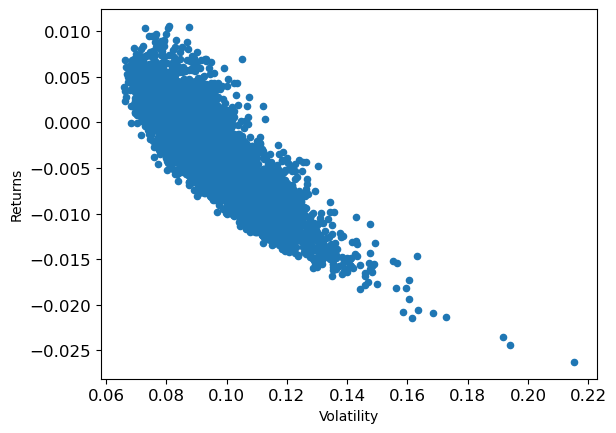

In [78]:
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

below is a function `optimal_portfolio()`. This function accepts the quarterly returns of a set of assets. 
The function returns the `weights`, `returns`, and `risks` of portfolios on the efficient frontiers. The returns are formatted as NumPy arrays.

In [79]:
!pip install cvxopt

In [80]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    opt.solvers.options['show_progress'] = False
    portfolios = [opt.solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = opt.solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

# 7. Calculate the set of portfolios on the EF

In [81]:
weights, returns, risks = optimal_portfolio(returns_quarterly[1:]);

Text(0.5, 1.0, 'Efficient Frontier')

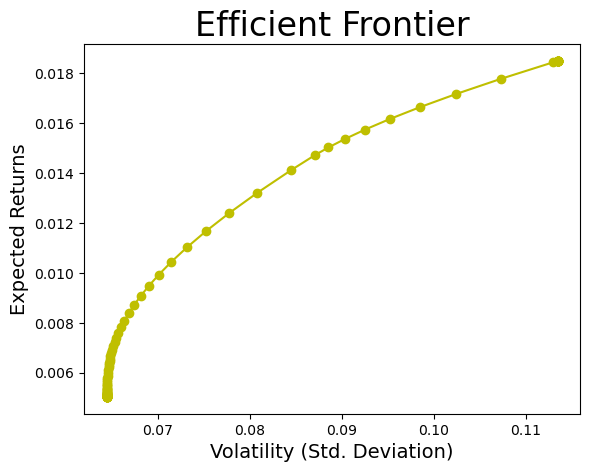

In [82]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns', fontsize=14)
plt.xlabel('Volatility (Std. Deviation)', fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

## How Do Two Additional Assets Affect the EF?

**stock_data_weak.csv**:

   Asset | Expected Return
   --- | ---
   General Electric | -0.0120
   Chesapeake Energy | -0.0306
   AT&T | -0.0014
   Cisco Systems | 0.0184
   Campbell Soup | 0.0084

 Visualize the efficient frontier for these assets.

In [83]:
path = 'stock_data_weak.csv'

# Load the stock data
stock_data = pd.read_csv(path)

# Find the quarterly for each period
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()

# Find the expected returns
expected_returns = returns_quarterly.mean()

# Find the covariance
cov_quarterly = returns_quarterly.cov()

# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)
# Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

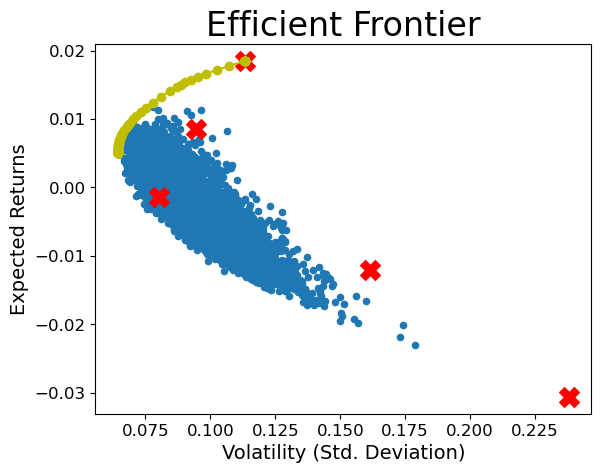

In [84]:
# Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
# Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

plt.show()

# Adding the two assets

In [85]:
# Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

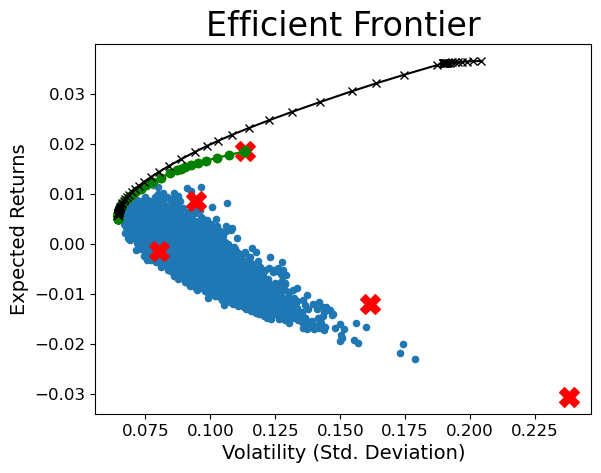

In [86]:
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)


# Compare the set of portfolios on the EF to the 
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

weak_EF = pd.read_csv('weak_risks_returns.csv')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')

strong_EF = pd.read_csv('strong_risks_returns.csv')
plt.plot(strong_EF['Risks'], strong_EF['Returns'], 'k-x')
# The efficient frontier did not change when you removed the two low return assets. Because these assets had low returns and were correlated to other assets in the portfolio, they didn’t improve the possible portfolios.


plt.show()

- Should you decide to diversify the portfolio with a couple of assets to increase the expected return of portfolios on the efficient frontier.

    You choose to add Bank of America and Marvel, so your assets are:
    
    Asset | Expected Return
    --- | ---
    General Electric | -0.0120
    Chesapeake Energy | -0.0306
    AT&T | -0.0014
    Cisco Systems | 0.0184
    Campbell Soup | 0.0084
    Bank of America | 0.0341
    Marvel | 0.0369
    
    Change the `path` variable to **stock_data2.csv** to visualize this new efficient frontier.

In [87]:
# Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

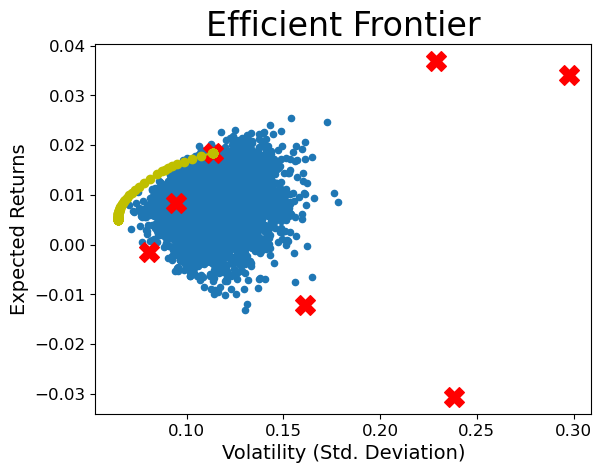

In [88]:

path = 'stock_data2.csv'

# Load the stock data
stock_data = pd.read_csv(path)

# Find the quarterly for each period
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()

# Find the expected returns
expected_returns = returns_quarterly.mean()

# Find the covariance
cov_quarterly = returns_quarterly.cov()

# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

# Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

# Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

plt.show()

# Compare the efficient frontiers to see how these two stocks have changed it

lets plot the original frontier on the same figure
It's hard to visualize how much the efficient frontier improved with these assets. Let's plot the original frontier on the same figure. Use the following code to do this:

   By adding the two high-return assets, we increased the expected return of portfolios on the efficient frontier.

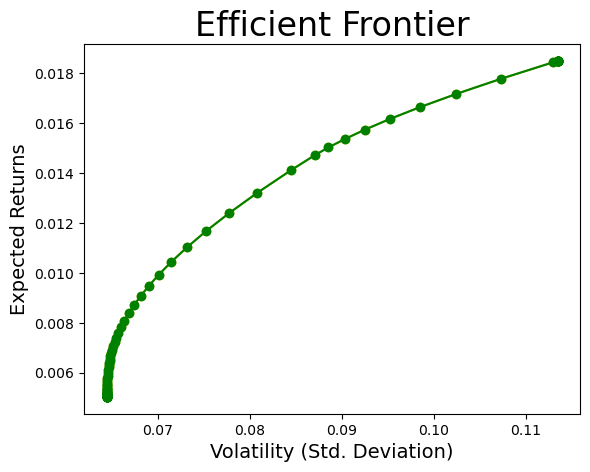

In [89]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
weak_EF = pd.read_csv('weak_risks_returns.csv')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')

- Looking at the expected returns of assets in your portfolio, you'll notice that General Electric and Chesapeake Energy have a large negative return; expects to lose money.

    Asset | Expected Return
    --- | ---
    General Electric | -0.0120
    Chesapeake Energy | -0.0306
    AT&T | -0.0014
    Cisco Systems | 0.0184
    Campbell Soup | 0.0084
    Bank of America | 0.0341
    Marvel | 0.0369
    
    This begs the question: do we need these assets in our portfolio? Given their poor expected return, we should only keep them if they are uniquely uncorrelated to the rest of the assets in the portfolio.
    

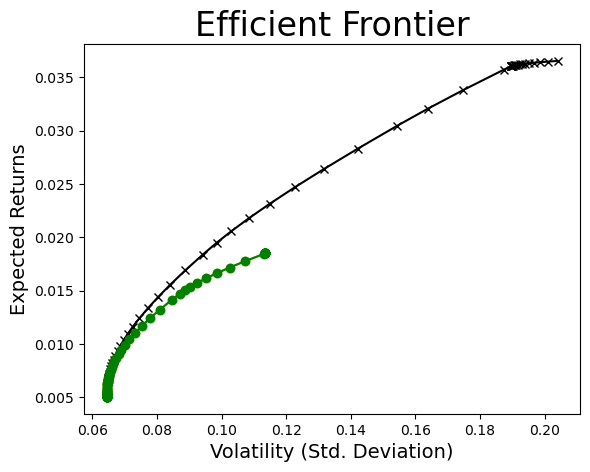

In [90]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
weak_EF = pd.read_csv('weak_risks_returns.csv')
strong_EF = pd.read_csv('strong_risks_returns.csv')
plt.plot(strong_EF['Risks'], strong_EF['Returns'], 'k-x')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')

## Finding the Best Efficient Frontier

**stock_data3.csv** contains ten assets
    
    You should see two efficient frontiers. We calculate the better efficient frontier (green dots) using all ten assets. We calculate the other efficient frontier using only five assets from the portfolio.
    
    I'm going to be looking at which 5 assets will be the best fit for the portfolio. 
    
    ```
    ['PFE', 'TGT', 'M', 'VZ', 'JPM', 'MRO', 'KO', 'PG', 'CVS', 'HPQ']
    ```

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path='stock_data3.csv'

# 1. Load the stock data
stock_data = pd.read_csv(path)
selected = list(stock_data.columns[1:])
# print(stock_data[selected].pct_change().mean())
# print(stock_data[selected].pct_change().cov())

#stock_names = ['PFE', 'TGT', 'M', 'VZ', 'JPM', 'MRO', 'KO', 'PG', 'CVS', 'HPQ']
selected = ['KO', 'HPQ', 'M', 'VZ', 'MRO']

# 2. Find the quarterly for each period
returns_quarterly = stock_data[selected].pct_change()

# 3. Find the expected returns 
expected_returns = returns_quarterly.mean()

# 4. Find the covariance 
cov_quarterly = returns_quarterly.cov()

# 5. Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly) 

# 7. Calculate the set of portfolios on the EF
# weights, returns, risks = optimal_portfolio(returns_quarterly[1:])


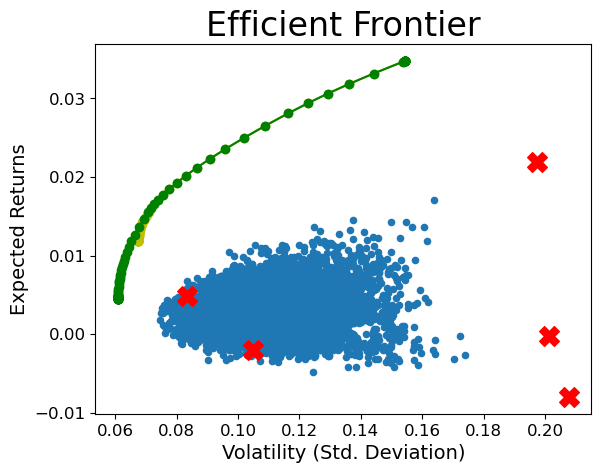

In [97]:
# 6. Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# 8. Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

#pd.DataFrame({'Risks': risks, 'Returns': returns}).to_csv('all_ten.csv', index=False)

# 9. Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

# All 10
all_ten_EF = pd.read_csv('all_ten.csv')
plt.plot(all_ten_EF['Risks'], all_ten_EF['Returns'], 'g-o')
plt.show()

Top 5 assets to invest in for the best Efficient Frontier

JPM    0.034781
VZ     0.004856
CVS    0.016124
TGT    0.014783
PFE    0.015530
dtype: float64
          JPM        VZ       CVS       TGT       PFE
JPM  0.023837 -0.000407  0.005041  0.007805  0.007016
VZ  -0.000407  0.006958  0.002052  0.002188  0.004071
CVS  0.005041  0.002052  0.011374  0.005384  0.004300
TGT  0.007805  0.002188  0.005384  0.012874  0.001738
PFE  0.007016  0.004071  0.004300  0.001738  0.010005


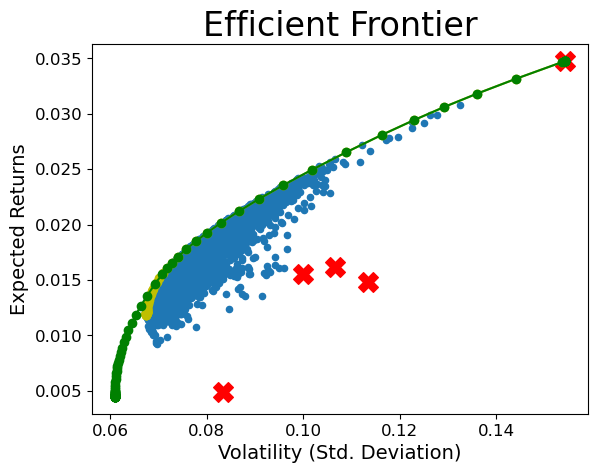

In [94]:
selected = ['JPM', 'VZ', 'CVS', 'TGT', 'PFE']
#selected = ['PFE', 'TGT', 'M', 'VZ', 'JPM', 'MRO', 'KO', 'PG', 'CVS', 'HPQ']

# 2. Find the quarterly for each period
returns_quarterly = stock_data[selected].pct_change()

# 3. Find the expected returns 
expected_returns = returns_quarterly.mean()
print(expected_returns)

# 4. Find the covariance 
cov_quarterly = returns_quarterly.cov()
print(cov_quarterly)

# 5. Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly) 

# 6. Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# 7. Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

# 8. Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

# 9. Compare the set of portfolios on the EF to the 
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

# All 10
all_ten_EF = pd.read_csv('all_ten.csv')
plt.plot(all_ten_EF['Risks'], all_ten_EF['Returns'], 'g-o')
plt.show()

In conclusion, we performed a detailed analysis of selected stocks by implementing portfolio optimization techniques. The stocks were chosen from the dataset obtained from 'stock_data3.csv'. The five selected stocks for this analysis were 'KO', 'HPQ', 'M', 'VZ', and 'MRO'.

Firstly, we calculated the quarterly returns and observed the average returns and covariance of these stocks. These metrics provided insights into the general performance and volatility of the selected stocks over time.

We then simulated random portfolios using the 'return_portfolios' function and plotted the random portfolios, which helped visualize the trade-off between risk (measured by volatility) and expected returns.

Next, we calculated the set of portfolios on the efficient frontier using the 'optimal_portfolio' function. The Efficient Frontier represents the set of optimal portfolios that offer the highest expected return for a defined level of risk.

Upon plotting the efficient frontier, we were able to compare it with our set of random portfolios. This comparison facilitated an understanding of the advantages of optimal portfolio selection.

Additionally, we plotted the risk-return trade-off for each individual asset. This scatter plot emphasized the benefit of diversification, as individual assets generally showed a worse risk-return trade-off compared to the portfolios on the Efficient Frontier.

Finally, we compared the Efficient Frontier of our selected five stocks with the Efficient Frontier of all ten stocks, which was previously saved in 'all_ten.csv'. This comparison helped identify how asset selection can impact the shape and extent of the Efficient Frontier, and ultimately, the optimal portfolios that can be achieved.

Thus, this analysis allowed us to understand the benefits of diversification, the concept of the Efficient Frontier, and the impact of asset selection on portfolio optimization.